# Humanitarian Crisis in Ukraine - Exploratory Analysis
## Svitlana Omural, March 12 2023

The ongoing war in Ukraine led to a humanitarian crisis, with millions of people in need of basic supplies. By analyzing real-time data we can gain critical insights into the needs of vulnerable populations, and make more informed decisions about how to invest and deliver our limited resources to respond.Â 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import json

In [2]:
# load ACLED data 
df_ukr = pd.read_csv("2022-02-01-2023-02-01-Europe-Ukraine.csv")

I'm using ACLED, an open-source database that tracks and reports on conflict and violence around the world. 
My data sample includes 38,922 reports on military attacks and subsequent events, time-stamped between 1 February 2022 and 1 February 2023.

In [3]:
df_ukr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38923 entries, 0 to 38922
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data_id           38923 non-null  int64  
 1   iso               38923 non-null  int64  
 2   event_id_cnty     38923 non-null  object 
 3   event_id_no_cnty  38923 non-null  int64  
 4   event_date        38923 non-null  object 
 5   year              38923 non-null  int64  
 6   time_precision    38923 non-null  int64  
 7   event_type        38923 non-null  object 
 8   sub_event_type    38923 non-null  object 
 9   actor1            38923 non-null  object 
 10  assoc_actor_1     2049 non-null   object 
 11  inter1            38923 non-null  int64  
 12  actor2            17873 non-null  object 
 13  assoc_actor_2     5057 non-null   object 
 14  inter2            38923 non-null  int64  
 15  interaction       38923 non-null  int64  
 16  region            38923 non-null  object

In [4]:
df_ukr.columns

Index(['data_id', 'iso', 'event_id_cnty', 'event_id_no_cnty', 'event_date',
       'year', 'time_precision', 'event_type', 'sub_event_type', 'actor1',
       'assoc_actor_1', 'inter1', 'actor2', 'assoc_actor_2', 'inter2',
       'interaction', 'region', 'country', 'admin1', 'admin2', 'admin3',
       'location', 'latitude', 'longitude', 'geo_precision', 'source',
       'source_scale', 'notes', 'fatalities', 'timestamp', 'iso3'],
      dtype='object')

In [5]:
# select columns
columns = ['event_date', 'event_type', 'sub_event_type', 'admin1', 'admin2', 'admin3', 'location', 'latitude', 
           'longitude', 'notes', 'fatalities', 'timestamp']
df_ukr = df_ukr[columns]

In [6]:
df_ukr.head()

event_date event_type sub_event_type   admin1        admin2  \
0  27 January 2023    Battles    Armed clash  Donetsk   Bakhmutskyi   
1  27 January 2023    Battles    Armed clash  Donetsk   Bakhmutskyi   
2  27 January 2023    Battles    Armed clash  Donetsk  Kramatorskyi   
3  27 January 2023    Battles    Armed clash  Donetsk   Bakhmutskyi   
4  27 January 2023    Battles    Armed clash  Donetsk   Bakhmutskyi   

              admin3     location  latitude  longitude  \
0         Bakhmutska      Bakhmut   48.5956    37.9999   
1         Soledarska  Bilohorivka   48.7329    38.2154   
2  Konstantinovskaya      Druzhba   48.4098    37.9104   
3         Bakhmutska    Ivanivske   48.5722    37.9174   
4         Bakhmutska  Klischiivka   48.5279    37.9582   

                                               notes  fatalities   timestamp  
0  On 27 January 2023, Russian forces shelled, as...           0  1675191966  
1  On 27 January 2023, Russian forces shelled, as...           0  1675191966  
2  On 27 January 2023, Russian forces shelled, as...           0  1675191966  
3  On 27 January 2023, Russian forces assaulted, ...           0  1675191966  
4  On 27 January 2023, Russian forces shelled, as...           0  1675191966

In [7]:
# group data by event type
df_ukr.groupby(['event_type', 'sub_event_type'])['notes'].count()

event_type                  sub_event_type                     
Battles                     Armed clash                             5625
                            Government regains territory             298
                            Non-state actor overtakes territory      235
Explosions/Remote violence  Air/drone strike                        2213
                            Grenade                                    8
                            Remote explosive/landmine/IED            412
                            Shelling/artillery/missile attack      27789
                            Suicide bomb                               2
Protests                    Excessive force against protesters        16
                            Peaceful protest                         188
                            Protest with intervention                 17
Riots                       Mob violence                               3
                            Violent demonstration           

The reports are categorized by event type. Most of the events reported are explosions/remote violence, especially shelling, artillery, and missile attacks. Furthermore, 5,625 armed clashes have been reported. Let's look at these events over time. 

In [ ]:
ukr_df = df_ukr[(df_ukr['event_type'] == 'Battles') | (df_ukr['event_type'] =='Explosions/Remote violence')]
ukr_df['date'] = pd.to_datetime(ukr_df['event_date'])
ukr_df = ukr_df.groupby(['date', 'event_type']).size().reset_index(name='event_count')

In [9]:
event_chart = alt.Chart(ukr_df).mark_line().encode(
    alt.X('date:T', title='Date'),
    alt.Y('event_count:Q', title='Event count'),
    color=alt.Color('event_type:N', title='Event type'),
    ).properties(
    title='Events over time',
    width=800,
    height=400
)

event_chart

/home/jovyan/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

The daily number of remote attacks and explosions is increasing over time, reaching up to 180 events a day total.

Let's map the conflict to identify areas most in need of assistance. 

In [10]:
with open('UA_FULL_Ukraine.geojson') as f:
    data = json.loads(f.read())

geo = pd.DataFrame(data['features'])

# Ukraine regions background
background = alt.Chart(geo).mark_geoshape(fill='lightgray', stroke='white')

# event positions on background
ukr_df = df_ukr.groupby(['admin2', 'latitude', 'longitude']).size().reset_index(name='lat_count')

points = alt.Chart(ukr_df).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='sum(lat_count)',
    groupby=['admin2']
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('count:Q', title='Number of events'),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='inferno')),
    tooltip=[alt.Tooltip('admin2:N', title='Region'), 
             alt.Tooltip('count:Q', title='Events')]
).properties(
    title='Events by region',
    width=800,
    height=500
)

background + points

/home/jovyan/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

Most attacks happen in Eastern Ukraine, especially in Donetsk region.

Next, let's classify war-damaged infrastructure to target humanitarian response. The war has extensively damaged infrastructure in Ukraine, including roads, bridges, water and electricity supplies, hospitals, schools, and residential buildings. Identifying the type of damaged infrastructure is essential for determining locations and people in need, and to inform the necessary allocation of resources needed for rebuilding.

In [11]:
pd.options.display.max_colwidth = 500

In [12]:
event = df_ukr['notes']

In [13]:
event[event.str.contains('residential|building|private house|apartment|shelter|hotel')].count()

1127

1,141 reports mention that a residential building, private house, apartment, hotel, or shelter have been damaged. 

In [14]:
# Examples of news reports about damaged shelter
event[event.str.contains('residential|building|private house|apartment|shelter|hotel')].head()

145                                                                                                                                                            On 26 January 2023, Ukrainian military forces shelled DPR's forces in Donetsk - Petrovskyi, Donetsk, damaging residential buildings. 2 civilians were wounded.
149                                                                                                                                                 On 26 January 2023, Ukrainian military forces shelled DPR's forces in Horlivka, Donetsk, damaging civilian infrastructure and a residential building. Casualties unknown.
150                                                                                                                                                                                           On 26 January 2023, Russian military forces shelled Huliaipole, Zaporizhia, damaging residential buildings. Casualties unknown.
156                                           

In [15]:
event[event.str.contains('hospital|clinic|blood transfusion centre|ambulance|medical|health|perinatal|maternity')].count()


185

192 reports mention that a medical facility was damaged.

In [16]:
# Examples of news reports about damaged medical facilities
event[event.str.contains('hospital|clinic|blood transfusion centre|ambulance|medical|health|perinatal|maternity')].head()

126                                                                                                                                                        On 26 January 2023, Russian military forces shelled Bakhmut, Donetsk, damaging a children's hospital. 2 civilians were wounded.
262                                                                                                           On 25 January 2023, Russian forces shelled Bakhmut, Donetsk region, having damaged a school, a hospital and the city council building. 1 civilian was killed, 1 was injured.
297                                                                                     On 25 January 2023, Russian forces shelled Kramatorsk, Donetsk region, hitting a local psychiatric hospital. At the time of shelling there were about 20 civilians in the building. No casualties.
350                                                                                                                                                    

Let's group reports by the type of damaged infrastructure. 

In [17]:
# define a function assigning a value to cells based on presence of keywords
# create a new column with tuples of assigned values if any of the keywords are present in the cell
def assign_values(df_column, keyword_value_tuples):
    new_column = []
    for cell in df_column:
        matched_values = []
        for keywords, value in keyword_value_tuples:
            if any(keyword in cell for keyword in keywords):
                matched_values.append(value)
        new_column.append(tuple(matched_values) if matched_values else None)
    return pd.Series(new_column)

In [18]:
# After careful analysis of the reports, I identified a list of importnat keywords 
# that would help to classify reports into 9 groups by damaged infrastructure
keyword_value_tuples = [
    (('hospital','clinic','blood transfusion centre','ambulance','medical','health','perinatal','maternity'), 'healthcare'),
    (('bridge','transport','vehicle','car','bus','road','depot','railroad','railway','airport','a port','boat','ferry','ship'), 'logistics'),
    (('residential','building','private house','apartment','shelter','hotel'), 'shelter'),
    (('school','kindergarten','college','university','education'), 'education'),
    (('power','powerlines','gas','water','heating','energy','electricity','electrical lines','pipeline'), 'power'),
    (('industrial','plant','factory','production'), 'industry'),
    (('cell phone','tv','television','radio','communication','network'), 'telecom'),
    (('farm','agricultural','agrarian','tractor','harvest','field','crops','grain','livestock'), 'agriculture'),
    (('market','supermarket','shop','store','warehouse','mall','shopping','bakery','food'), 'business')]

df_ukr['notes'] = df_ukr['notes'].str.lower()
new_column = assign_values(df_ukr['notes'], keyword_value_tuples)

df_ukr['classification'] = new_column

In [19]:
df_not_none = df_ukr.loc[df_ukr['classification'].notnull(), ['notes', 'classification']]
df_not_none.head(10)

notes  \
123                                                                                                                                                                                     looting: around 26 january 2023 (as reported), russian forces drove away a new batch of ukrainian grain from berdiansk, zaporizhia.   
126                                                                                                                                                                                         on 26 january 2023, russian military forces shelled bakhmut, donetsk, damaging a children's hospital. 2 civilians were wounded.   
128                                                                                                                                                                                  around 26 january 2023 (as reported), russian military forces shelled a civilian car near beryslav, kherson. 2 civilians were wounded.   
141                                                    on 26 january 2023, russian military forces shelled an industrial enterprise in the dnipropetrovsk region (coded to dnipro, dnipropetrovsk). earlier that day, the ukrainian military intercepted 5 russian kamikaze-drones in the region. there were no casualties.   
145                                                                                                                                                          on 26 january 2023, ukrainian military forces shelled dpr's forces in donetsk - petrovskyi, donetsk, damaging residential buildings. 2 civilians were wounded.   
149                                                                                                                                               on 26 january 2023, ukrainian military forces shelled dpr's forces in horlivka, donetsk, damaging civilian infrastructure and a residential building. casualties unknown.   
150                                                                                                                                                                                         on 26 january 2023, russian military forces shelled huliaipole, zaporizhia, damaging residential buildings. casualties unknown.   
156                                                                                                                                                                                                      on 26 january 2023, russian military forces shelled residential buildings in kherson, kherson. casualties unknown.   
168  on 26 january 2023, russian military forces launched 20 rockets at kyiv, kyiv. all the rockets were intercepted, but the remnants hit non-residential buildings, resulting in death of 1 and injuries of 2 civilians. the same day earlier, russia attacked kyiv with 15 kamikaze-drones, all of which were shot down.   
179                                                                                                                                                                                         on 26 january 2023, russian military forces shelled nova kakhovka, kherson, damaging residential buildings. casualties unknown.   

     classification  
123  (agriculture,)  
126   (healthcare,)  
128    (logistics,)  
141     (industry,)  
145      (shelter,)  
149      (shelter,)  
150      (shelter,)  
156      (shelter,)  
168      (shelter,)  
179      (shelter,)

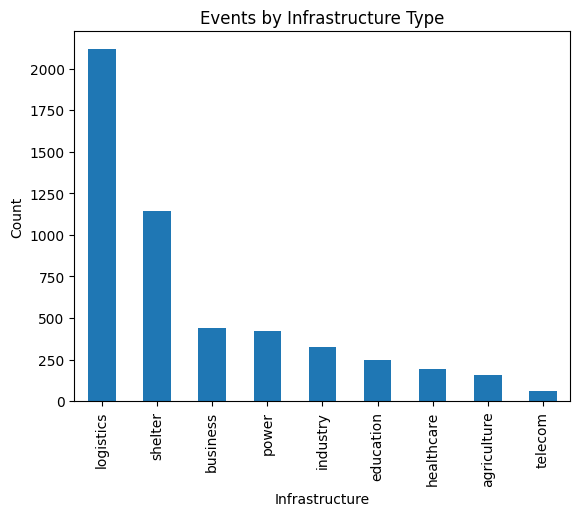

In [20]:
# explode tuples of strings in column 'classification', count occurrences, and plot histogram
counts = df_ukr['classification'].explode().value_counts()
counts.plot(kind='bar')

plt.title('Events by Infrastructure Type')
plt.xlabel('Infrastructure')
plt.ylabel('Count')

plt.show()

Using a set of relevant keywords, I classified the range of damaged infrastructure into nine categories: logistics, shelter, business, power/electricity/heating, industry, education, healthcare, agriculture, and telecom. 


Let's map damaged infrastructure.

In [21]:
# Select the columns you want to include in the exploded dataframe
cols_to_include = ['admin2', 'latitude', 'longitude', 'classification']

# Explode the selected columns
df = df_ukr[cols_to_include].explode('classification')
df = df.dropna()

In [22]:
df.head()

admin2  latitude  longitude classification
123   Berdianskyi   46.7586    36.7845    agriculture
126   Bakhmutskyi   48.5956    37.9999     healthcare
128  Beryslavskyi   46.8415    33.4284      logistics
141   Dniprovskyi   48.4593    35.0386       industry
145     Donetskyi   47.9495    37.6138        shelter

In [23]:
# event positions on background
df_infr = df.groupby(['admin2', 'latitude', 'longitude', 'classification']).size().reset_index(name='infr_count')

points = alt.Chart(df_infr).transform_aggregate(
    latitude='mean(latitude)',
    longitude='mean(longitude)',
    count='sum(infr_count)',
    groupby=['admin2', 'classification']
).mark_circle().encode(
    longitude='longitude:Q',
    latitude='latitude:Q',
    size=alt.Size('count:Q', title='Infrastructure Count'),
    color=alt.Color('count:Q', scale=alt.Scale(scheme='inferno')),
    tooltip=[alt.Tooltip('admin2:N', title='Region'),
             alt.Tooltip('classification:N', title='Infrastructure'),
             alt.Tooltip('count:Q', title='Count')]
).properties(
    title='Damaged infrastructure by region',
    width=800,
    height=500
)
   
background + points

/home/jovyan/.local/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

On this map we can see what type of infrastructure was damaged in different regions. 